### Подключение библиотек

In [107]:
import numpy
import pandas
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
%matplotlib inline


### Загрузка данных
Загрузим обработанные данные, полученные во время выполнения 2-го домашнего задания.

In [108]:
path = "../datasets/weatherAUS_stand.csv"
dataset = pandas.read_csv(path)

### Разбиваем данные на обучающую и тестовую выборки

In [109]:
numpy.random.seed(7)
random_subset = numpy.random.choice(
    numpy.arange(dataset.shape[0]), size=7500, replace=False)
dataset = dataset.iloc[random_subset]
X = dataset.drop(['RainTomorrow'], axis=1)
y = dataset['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=9)
N_test, _ = X_test.shape

### Обучение классификатора

In [110]:
mlp_model = MLPClassifier(hidden_layer_sizes=(50,),
                          solver='adam',
                          activation='relu',
                          random_state=3,
                          max_iter=1000)


In [111]:
%%time
mlp_model.fit(X_train, y_train)


Wall time: 33.6 s


MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=3)

### Проверяем качество классификатора

In [112]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

#### Точность на обучающей и тестовой выборке:

In [113]:
print("TRAIN: {:.2f}% TEST: {:.2f}%".format(accuracy_score(y_train, y_train_pred)
      * 100, accuracy_score(y_test, y_test_pred) * 100))


TRAIN: 99.71% TEST: 81.26%


Так как точность на тренировочной выборке сильно больше, чем на тестовой, то наблюдается переобучение.

### Подбор параметра регуляризации
Подберем оптимальное значение параметра регуляризации `alpha`

In [114]:
alpha_arr = numpy.logspace(-3, 2, 15)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha=alpha, hidden_layer_sizes=(50,),
                              solver='adam', activation='relu', max_iter=1000, random_state=9)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    train_err.append(numpy.mean(y_train != y_train_pred))
    test_err.append(numpy.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))


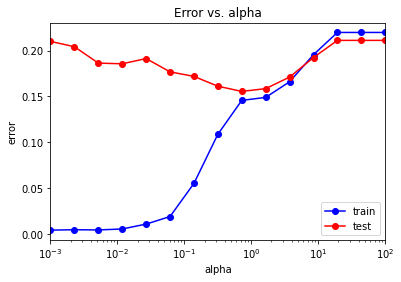

In [115]:
plt.semilogx(alpha_arr, train_err, 'b-o', label='train')
plt.semilogx(alpha_arr, test_err, 'r-o', label='test')
plt.xlim([numpy.min(alpha_arr), numpy.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()


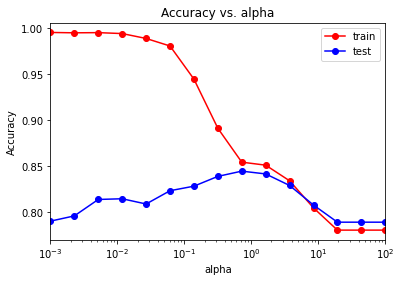

In [116]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label='train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label='test')
plt.xlim([numpy.min(alpha_arr), numpy.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()


Из графика видим, что при небольших значения параметра регуляризации (примерно `alpha` < 1) наблюдается переобучение. Начиная с `alpha_opt` точность и на тествой и на обучающей выборке совпадает, то есть получаем оптимальное значения для параметра регуляризации. При дальнейшем увеличении `alpha` точность уменьшается, то есть наблюдается недообучение.  

Минимальное значение ошибки:

In [117]:
min_train_err = numpy.min(train_err)
min_test_err = numpy.min(test_err)
print("TRAIN:", min_train_err, "TEST:", min_test_err)

TRAIN: 0.0043076923076923075 TEST: 0.15542857142857142


Оптимальное значение alpha:

In [118]:
alpha_opt = alpha_arr[test_err == min_test_err]
print("Alpha opt:", alpha_opt)

Alpha opt: [0.71968567]


### Классификатор при найденном оптимальном значении alpha:

In [119]:
mlp_model = MLPClassifier(alpha=alpha_opt, hidden_layer_sizes=(50,),
                          solver='adam', activation='relu', random_state=7)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)


#### Точность на обучающей и тестовой выборке:

In [120]:
print("TRAIN: {:.2f}% TEST: {:.2f}%".format(accuracy_score(y_train, y_train_pred)
      * 100, accuracy_score(y_test, y_test_pred) * 100))


TRAIN: 85.60% TEST: 84.42%


### Матрица рассогласования:

In [121]:
print(confusion_matrix(y_test_pred, y_test))

[[1968  306]
 [ 103  248]]


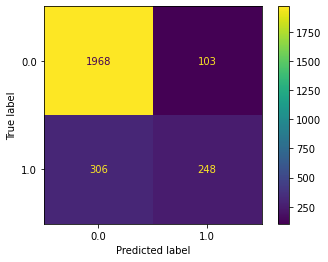

In [122]:
predictions = mlp_model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=mlp_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
disp.plot()
plt.show()

 ### Подбор числа нейронов

In [123]:
neuron_count_array = numpy.linspace(10, 300, 30).astype(int)
test_error = []
train_error = []
test_acc = []
train_acc = []

for neuron_count in neuron_count_array:
    model = MLPClassifier(
        alpha=alpha_opt,
        hidden_layer_sizes=(neuron_count,),
        solver='adam',
        activation='relu',
        max_iter=1000,
        random_state=7
    )
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    test_error.append(numpy.mean(y_test != y_test_pred))
    train_error.append(numpy.mean(y_train != y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))


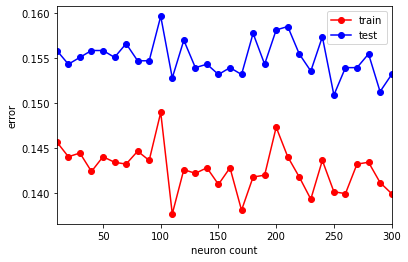

In [124]:
plt.plot(neuron_count_array, train_error, 'r-o', label='train')
plt.plot(neuron_count_array, test_error, 'b-o', label='test')
plt.xlim([numpy.min(neuron_count_array), numpy.max(neuron_count_array)])
plt.xlabel('neuron count')
plt.ylabel('error')
plt.legend()


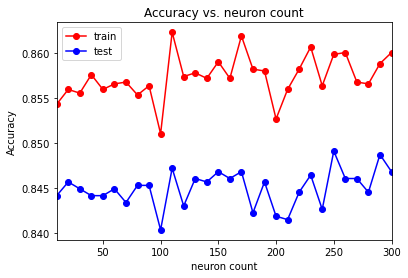

In [125]:
plt.plot(neuron_count_array, train_acc, 'r-o', label='train')
plt.plot(neuron_count_array, test_acc, 'b-o', label='test')
plt.xlim([numpy.min(neuron_count_array), numpy.max(neuron_count_array)])
plt.title('Accuracy vs. neuron count')
plt.xlabel('neuron count')
plt.ylabel('Accuracy')
plt.legend()


In [126]:
min_test_error = numpy.min(test_error)
neuron_opt = neuron_count_array[test_error == min_test_error][0]
print('Optimal neuron count: {}'.format(neuron_opt))

Optimal neuron count: 250


Не наблюдается явной зависимости между количеством нейронов и точностью, но можно выделить некоторое оптимальное значение числа нейронов 250, в нем была наилучшая точность на тестовой выборке.

### Классификатор при найденном оптимальном значении числа нейронов:

In [127]:
mlp_model = MLPClassifier(alpha=alpha_opt, hidden_layer_sizes=(neuron_opt,),
                          solver='adam', activation='relu', max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

#### Точность на обучающей и тестовой выборке:

In [128]:
print("TRAIN: {:.2f}% TEST: {:.2f}%".format(accuracy_score(y_train, y_train_pred)
      * 100, accuracy_score(y_test, y_test_pred) * 100))

TRAIN: 85.66% TEST: 84.61%


При заданных оптимальных значенях параметра регуляризации и числа нейронов не наблюдается переобучения.

### Подбор оптимального значения параметра регуляризации и числа нейронов

In [129]:
neuron_arr = numpy.linspace(10, 300, 5).astype(int)
alpha_arr = numpy.logspace(-3, 2, 5)
test_err = []
train_err = []
train_acc = []
test_acc = []
neuron_alpha_opt = []

for neuron in neuron_arr:
    for alpha in alpha_arr:
        mlp_model = MLPClassifier(alpha=alpha, hidden_layer_sizes=(neuron,),
                                  solver='adam', activation='relu', max_iter=1500, random_state=3)
        mlp_model.fit(X_train, y_train)

        y_train_pred = mlp_model.predict(X_train)
        y_test_pred = mlp_model.predict(X_test)

        train_err.append(numpy.mean(y_train != y_train_pred))
        test_err.append(numpy.mean(y_test != y_test_pred))
        train_acc.append(accuracy_score(y_train, y_train_pred))
        test_acc.append(accuracy_score(y_test, y_test_pred))
        neuron_alpha_opt.append([neuron, alpha])


In [130]:
min_test_err = numpy.min(test_err)
i, = numpy.where(test_err == min_test_err)
neuron_opt, alpha_opt = neuron_alpha_opt[i[0]]
print("Neuron count opt:", neuron_opt)
print("Alpha opt: ", alpha_opt)


Neuron count opt: 82
Alpha opt:  0.31622776601683794


### Классификатор при найденных оптимальных значениях:

In [131]:
mlp_model = MLPClassifier(alpha=alpha_opt, hidden_layer_sizes=(neuron_opt,),
                          solver='adam', activation='relu', max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)


#### Точность на обучающей и тестовой выборке:

In [132]:
print("TRAIN: {:.2f}% TEST: {:.2f}%".format(accuracy_score(y_train, y_train_pred)
      * 100, accuracy_score(y_test, y_test_pred) * 100))


TRAIN: 90.48% TEST: 84.69%


## Выводы:
* За счет подбра оптимального параметра регуляризации, можно избавиться от переобучения, тем самым повысить точность на тестовой выборке;
* Подбор оптимального числа нейронов, при оптимальном значении регулярации, немного повысил точность на тестовой выборке;
* При одноверенном подборе обоих параметров мы избавляемся от переобучения и повышаем точность на обучающей выборке, при этом не теряя точность на тестовой.